# Machine Learning analysis

- This is a Python base notebook  

Kaggle's [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/home) dataset contains a number of features of songs from 2017 and a binary variable `target` that represents whether the user liked the song (encoded as 1) or not (encoded as 0). See the documentation of all the features [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/). 

## Imports

### Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer

#from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    RandomizedSearchCV,
#    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import make_pipeline #Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#from sklearn.svm import SVC, SVR
#from sklearn.preprocessing import PolynomialFeatures

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
#from sklearn.feature_selection import RFECV

from sklearn.metrics import (
    classification_report,
    roc_curve,
    RocCurveDisplay,
    roc_auc_score
)

import shap
#from sklearn.model_selection import cross_val_predict

In [2]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

<br><br>

### Reading the data CSV
Read in the data CSV and store it as a pandas dataframe named `spotify_df`.

In [3]:
spotify_df = pd.read_csv('data/spotify_data.csv', index_col = 0 )
spotify_df.head(6)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys
5,0.00479,0.804,251333,0.560,0.000000,8,0.1640,-6.682,1,0.1850,85.023,4.0,0.264,1,Sneakin’,Drake


## Data splitting
Split the data into train and test portions. Remove `song_title`, separate data to `X_train`, `y_train`, `X_test`, `y_test`.

In [4]:
train_df, test_df = train_test_split(spotify_df, test_size=0.2, random_state=123)
X_train, y_train = train_df.drop(columns=["target"]), train_df["target"].astype('category')
X_test, y_test = test_df.drop(columns=["target"]), test_df["target"].astype('category')

In [5]:
# printing the number of observations for train and test sets
print('The number of observations for train set: ', train_df['target'].shape[0])
print('The number of observations for test set: ', test_df['target'].shape[0])

The number of observations for train set:  1613
The number of observations for test set:  404


I split 20% of the observations in the test data and 80% in the train data set. Overall the data set has about 2,000 observations, as it is not a very large data set, I preserved more portion for training.

## Scoring metric

Since it is a balanced data set and both positive and negative class are equally balanced, accuracy and precision-recall curves are selected as scoring metric.

In [6]:
scoring_metric = ["accuracy", "roc_auc"]

## Feature engineering (TBC)
In feature enginnering, we carry out feature engineering, extract new features that are relevant for the problem. For Spotify data set, I added the feature genres which are extracted from Spotify API. To understand more about the data extraction, you can do to appendix.

## Preprocessing and transformations 
Here is different feature types and the transformations I will apply on each feature type. 

|     Type | Reason                                                                                                                                                                                                                                         | Features                                                                                                                                                                                                |
|---------:|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| category |All of these features have fixed number of categories. `key` is circulated features like months. `artist`, `genres`, `artist_style` have limited categories. | `key`, `artist`, `genres`, `artist_style`|
| numeric  | Numeric columns needs standardization | `acousticness`, `danceability`, `duration_ms`, `energy`, `instrumentalness`, `liveness`, `loudness`, `mode`, `speechiness`, `tempo`, `time_signature`, `valence`|
| drop     | Free text column which has low correlation with target.| `song_title` |

In [7]:
category_feats = ["key", "artist"]
drop_feats = ['song_title']

numeric_feats  = list(set(X_train.columns)
            - set(category_feats)
            - set(drop_feats)
        )

preprocessor = make_column_transformer(
    ("drop", drop_feats),
    (StandardScaler(), numeric_feats),
    (OneHotEncoder(handle_unknown="ignore", sparse=False), category_feats)
)
preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('drop', 'drop', ['song_title']),
                                ('standardscaler', StandardScaler(),
                                 ['energy', 'instrumentalness', 'tempo',
                                  'loudness', 'speechiness', 'liveness',
                                  'danceability', 'time_signature',
                                  'duration_ms', 'valence', 'acousticness',
                                  'mode']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['key', 'artist'])])

## Baseline model

In [8]:
results = {}

In [9]:
dummy = DummyClassifier()
baseline_pipe = make_pipeline(preprocessor, dummy)
results['dummy'] = mean_std_cross_val_scores(make_pipeline(preprocessor, dummy), X_train, y_train, 
                                             return_train_score=True, scoring=scoring_metric)

In [10]:
pd.DataFrame(results)

,dummy
fit_time,0.015 (+/- 0.002)
score_time,0.013 (+/- 0.002)
test_accuracy,0.508 (+/- 0.001)
train_accuracy,0.508 (+/- 0.000)
test_roc_auc,0.500 (+/- 0.000)
train_roc_auc,0.500 (+/- 0.000)


Accuracy of Dummy classifier depends on class ratio. As we have a balanced data set, the accuracy of Dummy classifier is around 50%.

## Linear models
### Model training - LogisticRegression
First, a linear model is used as a first real attempt. Hyperparameter tuning is also carried out for tuning to explore different values for the regularization hyperparameter. Cross-validation scores along with standard deviation and results summary is shown in below.

In [11]:
#pipe logistic regression
pipe_logisticregression = make_pipeline(preprocessor,
                           LogisticRegression(max_iter=2000, 
                                             random_state=123))

In [12]:
#save in the results logistic regression score
results["LogisticReg"] = mean_std_cross_val_scores(pipe_logisticregression, 
                                                   X_train, 
                                                   y_train, 
                                                   return_train_score=True,
                                                   scoring = scoring_metric)
pd.DataFrame(results)

,dummy,LogisticReg
fit_time,0.015 (+/- 0.002),0.072 (+/- 0.018)
score_time,0.013 (+/- 0.002),0.014 (+/- 0.001)
test_accuracy,0.508 (+/- 0.001),0.734 (+/- 0.032)
train_accuracy,0.508 (+/- 0.000),0.891 (+/- 0.005)
test_roc_auc,0.500 (+/- 0.000),0.805 (+/- 0.034)
train_roc_auc,0.500 (+/- 0.000),0.952 (+/- 0.002)


### hyperparameter optimization

We will carry out hyperparameter optimization: C controls the regularization, and class_weight hyperparameter for tackling class imbalance. 

In [13]:
#parameters for logistic regression
param_dist_lg = {'logisticregression__C': np.linspace(2, 3, 6),
                 'logisticregression__class_weight': ['balanced', None]}

#randomized search to find the best parameters
random_search_lg = RandomizedSearchCV(
    pipe_logisticregression, 
    param_dist_lg,
    n_jobs=-1,
    return_train_score=True,
    scoring = scoring_metric,
    refit='accuracy',
    random_state=123
)

In [14]:
random_search_lg.fit(X_train, y_train)
print("Best parameter values are:", random_search_lg.best_params_)
print("Best cv score is:", random_search_lg.best_score_)

Best parameter values are: {'logisticregression__class_weight': 'balanced', 'logisticregression__C': 2.8}
Best cv score is: 0.7582293329231007


In [15]:
results['LogisticReg_opt'] = mean_std_cross_val_scores(random_search_lg, 
                                                       X_train, 
                                                       y_train, 
                                                       return_train_score=True,
                                                       scoring = scoring_metric)

In [16]:
pd.DataFrame(results)

,dummy,LogisticReg,LogisticReg_opt
fit_time,0.015 (+/- 0.002),0.072 (+/- 0.018),5.671 (+/- 0.304)
score_time,0.013 (+/- 0.002),0.014 (+/- 0.001),0.018 (+/- 0.003)
test_accuracy,0.508 (+/- 0.001),0.734 (+/- 0.032),0.758 (+/- 0.035)
train_accuracy,0.508 (+/- 0.000),0.891 (+/- 0.005),0.971 (+/- 0.004)
test_roc_auc,0.500 (+/- 0.000),0.805 (+/- 0.034),0.840 (+/- 0.030)
train_roc_auc,0.500 (+/- 0.000),0.952 (+/- 0.002),0.993 (+/- 0.002)


We can see that with optimized hyperparameters, Logistic Regression is doing a bit better. However, it is obvious that we are dealing with overfitting (big gap between test and training scores and the training accuracy is almost 100%). The std is very small ranging in +- 0.01. 

In [17]:
print(
    classification_report(
        y_train,
        random_search_lg.predict_proba(X_train)[:, 1] > 0.5,
        target_names=["0", "1"],
    )
)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       794
           1       0.98      0.96      0.97       819

    accuracy                           0.97      1613
   macro avg       0.97      0.97      0.97      1613
weighted avg       0.97      0.97      0.97      1613



Area under the curve (AUC): 0.993


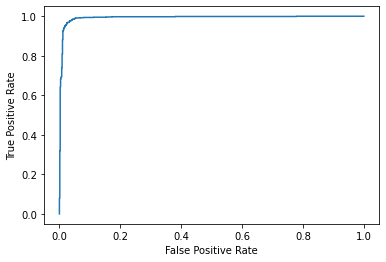

In [18]:
fpr, tpr, _ = roc_curve(
    y_train,
    random_search_lg.predict_proba(X_train)[:, 1],
    pos_label=random_search_lg.classes_[1],
)
print(
    "Area under the curve (AUC): {:.3f}".format(
        roc_auc_score(y_train, random_search_lg.predict_proba(X_train)[:, 1])
    )
)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

We have high score in AUC and classification report, which means our prediction model performance is good.

### Model interpretation on Training set

Most important features are listed in below.

In [19]:
col_name_pp_all = [
    *numeric_feats,
    *random_search_lg.best_estimator_.named_steps["columntransformer"]
    .named_transformers_["onehotencoder"]
    .get_feature_names_out(),
]

data = {
    "Importance": random_search_lg.best_estimator_.named_steps[
        "logisticregression"
    ].coef_[0],
}
feat_importance = pd.DataFrame(data=data, index=col_name_pp_all).sort_values(
    by="Importance", ascending=False
)

feat_importance_200 = pd.concat([feat_importance[0:99], feat_importance[-100:]])
feat_importance_200["rank"] = feat_importance_200["Importance"].rank(ascending=False)
feat_importance_200["side"] = np.where(
    feat_importance_200["Importance"] > 0, "pos", "neg"
)
feat_importance_200

,Importance,rank,side
artist_FIDLAR,2.807141,1.0,pos
artist_Beach House,2.541964,2.0,pos
artist_Perfume Genius,2.499702,3.0,pos
artist_Kanye West,2.472228,4.0,pos
artist_Crystal Castles,2.439233,5.0,pos
...,...,...,...
artist_Backstreet Boys,-2.023535,195.0,neg
artist_*NSYNC,-2.058217,196.0,neg
artist_Fall Out Boy,-2.102519,197.0,neg
artist_WALK THE MOON,-2.150688,198.0,neg


Most of the important features are determined by `artists`. Excluding all the features from artist, the other important features are `key`, `danceability` and `duration`. However, the ranking of importance are pretty low, starting from #423.

In [20]:
feat_importance_reset = feat_importance.reset_index()
feat_importance_reset[feat_importance_reset['index'].str.match('^(?![artist])')]

,index,Importance
423,key_2,0.513700
489,danceability,0.356366
508,duration_ms,0.309779
525,valence,0.265947
529,key_9,0.247395
536,key_10,0.209361
549,key_0,0.085376
550,liveness,0.083531
552,energy,0.018710
553,key_4,0.016735


In [21]:
import altair as alt

base = (
    alt.Chart(feat_importance_200.reset_index())
    .mark_bar()
    .encode(
        x=alt.X(
            "index",
        ),
        y="Importance:Q",
        color="side",
    )
    .properties(height=200, width=800, title="Top 200 important features")
)

brush = alt.selection_interval(encodings=["x"])
lower = (
    base.encode(
        x=alt.X(
            "index",
            axis=alt.Axis(labels=False, title="Features"),
            sort=alt.SortField(field="rank", order="ascending"),
        )
    )
    .properties(height=60, width=800, title="Drag the plot in below to zoom")
    .add_selection(brush)
)

upper = base.encode(
    alt.X(
        "index",
        scale=alt.Scale(domain=brush),
        axis=alt.Axis(title=""),
        sort=alt.SortField(field="rank", order="ascending"),
    )
)

upper & lower

alt.VConcatChart(...)

Top 200 most important features are based on artists.

<br><br>

## Non-linear models
### Model training - RandomForestClassifier, XGBClassifier, LGBMClassifier, CatBoostClassifier
Second, four non-linear model are trained aside from the linear model above.  
After that, feature selection and hyperparameter tuning will carried out in later stage. Cross-validation scores along with standard deviation and results summary is shown in below.

In [22]:
# Random Forest pipe
pipe_rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=123))

# XGBoost pipe
pipe_xgb = make_pipeline(
    preprocessor,
    XGBClassifier(
        random_state=123, eval_metric="logloss", verbosity=0, use_label_encoder=False
    ),
)

# LGBM Classifier pipe
pipe_lgbm = make_pipeline(preprocessor, LGBMClassifier(random_state=123))

# Catboost pipe
pipe_catb = make_pipeline(preprocessor, CatBoostClassifier(verbose=0, random_state=123))

models = {
    "RandomForest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LGBM": pipe_lgbm,
    "Cat_Boost": pipe_catb,
}

# summarize mean cv scores in result_non_linear
for (name, model) in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

In [23]:
pd.DataFrame(results)

,dummy,LogisticReg,LogisticReg_opt,RandomForest,XGBoost,LGBM,Cat_Boost
fit_time,0.015 (+/- 0.002),0.072 (+/- 0.018),5.671 (+/- 0.304),0.593 (+/- 0.014),1.083 (+/- 0.050),0.083 (+/- 0.017),2.924 (+/- 0.143)
score_time,0.013 (+/- 0.002),0.014 (+/- 0.001),0.018 (+/- 0.003),0.054 (+/- 0.002),0.021 (+/- 0.002),0.016 (+/- 0.002),0.143 (+/- 0.011)
test_accuracy,0.508 (+/- 0.001),0.734 (+/- 0.032),0.758 (+/- 0.035),0.797 (+/- 0.039),0.760 (+/- 0.021),0.773 (+/- 0.014),0.790 (+/- 0.025)
train_accuracy,0.508 (+/- 0.000),0.891 (+/- 0.005),0.971 (+/- 0.004),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),0.932 (+/- 0.003)
test_roc_auc,0.500 (+/- 0.000),0.805 (+/- 0.034),0.840 (+/- 0.030),0.865 (+/- 0.030),0.842 (+/- 0.034),0.850 (+/- 0.028),0.863 (+/- 0.031)
train_roc_auc,0.500 (+/- 0.000),0.952 (+/- 0.002),0.993 (+/- 0.002),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),0.990 (+/- 0.001)


All the non-linear models are overfitting as all the training scores are close to 1. Compared to most of the models, `CatBoost` is the most balanced model in performance, it has the highest accuracy and comparatively less overfitting (the gap between train and validation scores is smaller).

However, the fit time for`cat_boost` is slow. It may be a concern as the algorithm is likely to refit every user by the latest song listening history whenever the user wants to update their playlist. Moreover, the score time of `cat_boost` is the slowest among all models but acceptable.

Stability of scores is more or less stable, with standard deviation ranging in around 0.01. 

### Hyperparameter optimization (Very time consuming, TBC)

Hyperparamaters optimization is performed for `CatBoostClassifier`:  
**max_depth** which determines the the depth of the tree  
**learning_rate** which controls the gradient step size (smaller size, more iterations) and can help to minimize the error associated with the Loss function

In [24]:
param_grid_cat = {
     "catboostclassifier__max_depth": np.arange(5, 15, 2),
     "catboostclassifier__learning_rate": np.linspace(0.1,0.2,5)
}

<br><br>

### Model interpretation on Training set

Since `feature_importance_` is not supported on the models, `shap` is used to examine the most important features of our best non-linear models. 

In [25]:
pipe_catb.fit(X_train, y_train);

In [26]:
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=col_name_pp_all,
    index=X_train.index,
)

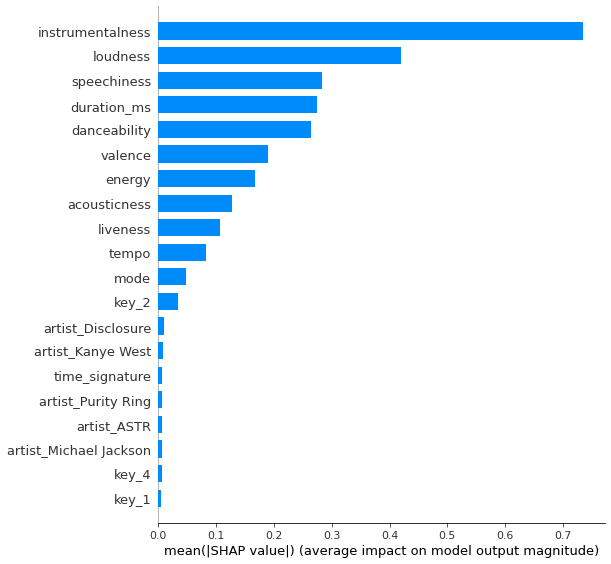

In [27]:
catboost_explainer = shap.TreeExplainer(pipe_catb.named_steps["catboostclassifier"])
train_catboost_shap_values = catboost_explainer.shap_values(X_train_enc)
shap.summary_plot(train_catboost_shap_values, X_train_enc, plot_type="bar")

We examined the most important features of `CatBoostClassifier` with SHAP methods. The results suggests that the most important feature are `instrumentalness`, `loudness` and `speechiness`. It introduced a very different results comparing to the linear model, which suggested `artist` is the most important features. 

One interesting observation from the result here is that, the importance of `artist` suggested by two models are different too. Top 3 `artist` from linear model are **FIDLAR**, **Beach House**, **Perfume Genius**, while top 3 `artist` from linear model are **Disclosure**, **Kanye West** and **Purity Ring**. Nevertheless, all of the artists above are noticeable from EDA **Artist like world cloud**.

## Model Averaging
`CatBoostClassifier` has long processing time but the other models are overfitted. To ease the fundamental trade off, `Averaging` is attempted to see if a higher validation score and shorter fit time can be achieved.

In [28]:
avg_classifiers = {
    "random forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm
}

averaging_model = VotingClassifier(
    list(avg_classifiers.items()), voting="soft"
) 

results['averaging'] = mean_std_cross_val_scores(
        averaging_model, X_train, y_train, return_train_score=True, scoring=scoring_metric#, cv=2
    )

In [29]:
pd.DataFrame(results)

,dummy,LogisticReg,LogisticReg_opt,RandomForest,XGBoost,LGBM,Cat_Boost,averaging
fit_time,0.015 (+/- 0.002),0.072 (+/- 0.018),5.671 (+/- 0.304),0.593 (+/- 0.014),1.083 (+/- 0.050),0.083 (+/- 0.017),2.924 (+/- 0.143),1.715 (+/- 0.347)
score_time,0.013 (+/- 0.002),0.014 (+/- 0.001),0.018 (+/- 0.003),0.054 (+/- 0.002),0.021 (+/- 0.002),0.016 (+/- 0.002),0.143 (+/- 0.011),0.074 (+/- 0.004)
test_accuracy,0.508 (+/- 0.001),0.734 (+/- 0.032),0.758 (+/- 0.035),0.797 (+/- 0.039),0.760 (+/- 0.021),0.773 (+/- 0.014),0.790 (+/- 0.025),0.771 (+/- 0.017)
train_accuracy,0.508 (+/- 0.000),0.891 (+/- 0.005),0.971 (+/- 0.004),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),0.932 (+/- 0.003),1.000 (+/- 0.000)
test_roc_auc,0.500 (+/- 0.000),0.805 (+/- 0.034),0.840 (+/- 0.030),0.865 (+/- 0.030),0.842 (+/- 0.034),0.850 (+/- 0.028),0.863 (+/- 0.031),0.857 (+/- 0.029)
train_roc_auc,0.500 (+/- 0.000),0.952 (+/- 0.002),0.993 (+/- 0.002),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),0.990 (+/- 0.001),1.000 (+/- 0.000)


According to the result, averaging the models neither help the overfitting issue nor scoring. However, the fit score is indeed faster than `Cat_Boost`. `CatBoostClassifier` is still the best model.

## Results on the test set 

The best performing model `CatBoostClassifier` is used on the test data and report test scores. Summary is shown as below. Furthermore, some test predictions and corresponding explanation with SHAP force plots are drawn for further study.

In [30]:
#predictions = pipe_catb.predict(X_test)
print("Test Set accuracy: ", round(pipe_catb.score(X_test, y_test), 3))

Test Set accuracy:  0.772


The test set's score were slightly lower than the validation score. Therefore, the prediction is promising. 

### Interpretation and feature importances on Test set

In [31]:
# Encoding X_test for SHAP force plot
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=col_name_pp_all,
    index=X_test.index,
)
X_test_enc.shape

(404, 1155)

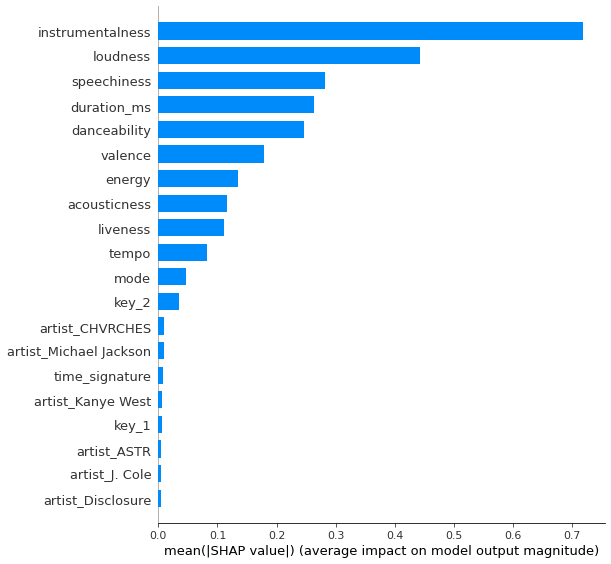

In [32]:
# Create an explainer for X_test_enc
test_catboost_shap_values = catboost_explainer.shap_values(X_test_enc)
shap.summary_plot(test_catboost_shap_values, X_test_enc, plot_type="bar")

In [33]:
y_test.iloc[3]

0

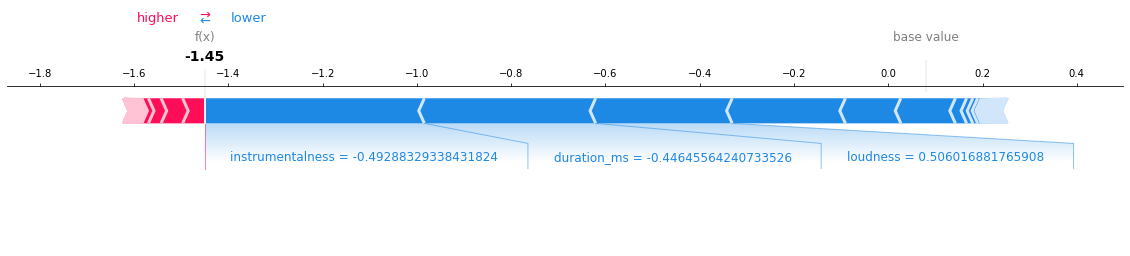

In [34]:
# Force Plot for prediction of 4th row (no_default)
shap.force_plot(
    catboost_explainer.expected_value,
    test_catboost_shap_values[3,:],
    X_test_enc.iloc[3,:],
    matplotlib=True,
)

- As seen from the plot, the raw score is much smaller than the base value, which predict accurately as **Unlike** (class of '0').  
- `speechiness` is pushing the prediction towards a higher score, and `instrumentalness` and `duration_ms` are pushing the prediction towards a lower score.

In [35]:
y_test.iloc[1]

1

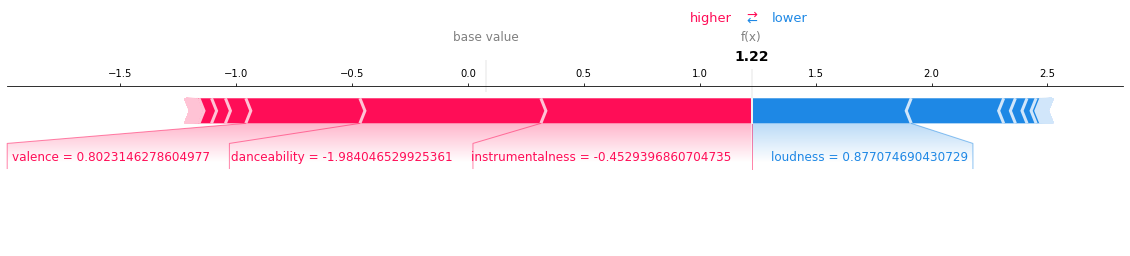

In [36]:
# Force Plot for prediction of 2nd row (no_default)
shap.force_plot(
    catboost_explainer.expected_value,
    test_catboost_shap_values[1,:],
    X_test_enc.iloc[1,:],
    matplotlib=True,
)

- As seen from the plot, the raw score is much smaller than the base value, which predict accurately as **Unlike** (class of '0').  
- `instrumentalness` and `duration_ms` are pushing the prediction towards a higher score, and `loudness` is pushing the prediction towards a lower score.

## Summary of machine learning results 

In [37]:
pd.DataFrame(results)

,dummy,LogisticReg,LogisticReg_opt,RandomForest,XGBoost,LGBM,Cat_Boost,averaging
fit_time,0.015 (+/- 0.002),0.072 (+/- 0.018),5.671 (+/- 0.304),0.593 (+/- 0.014),1.083 (+/- 0.050),0.083 (+/- 0.017),2.924 (+/- 0.143),1.715 (+/- 0.347)
score_time,0.013 (+/- 0.002),0.014 (+/- 0.001),0.018 (+/- 0.003),0.054 (+/- 0.002),0.021 (+/- 0.002),0.016 (+/- 0.002),0.143 (+/- 0.011),0.074 (+/- 0.004)
test_accuracy,0.508 (+/- 0.001),0.734 (+/- 0.032),0.758 (+/- 0.035),0.797 (+/- 0.039),0.760 (+/- 0.021),0.773 (+/- 0.014),0.790 (+/- 0.025),0.771 (+/- 0.017)
train_accuracy,0.508 (+/- 0.000),0.891 (+/- 0.005),0.971 (+/- 0.004),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),0.932 (+/- 0.003),1.000 (+/- 0.000)
test_roc_auc,0.500 (+/- 0.000),0.805 (+/- 0.034),0.840 (+/- 0.030),0.865 (+/- 0.030),0.842 (+/- 0.034),0.850 (+/- 0.028),0.863 (+/- 0.031),0.857 (+/- 0.029)
train_roc_auc,0.500 (+/- 0.000),0.952 (+/- 0.002),0.993 (+/- 0.002),1.000 (+/- 0.000),1.000 (+/- 0.000),1.000 (+/- 0.000),0.990 (+/- 0.001),1.000 (+/- 0.000)


Amongst the models, it is clear that `CatBoostClassifier` has the best accuracy and ROC AUC score. Moreover, the difference in scores between the test set and validation set are comparatively small, suggesting that there is minimal optimisation bias. Based on our test scores, our model is able to identify about **77.2%** of the cases.

One thing that needs to be kept in mind is that, the fit time for`cat_boost` is slow. It can be a concern as the algorithm is likely to refit every user by the latest song listening history whenever the user wants to update their playlist. Moreover, the score time of `Cat_Boost` is the slowest among all models but acceptable. The processing time (fit + score time) is critical for the application.  

Hence, the other options after `Cat_Boost` may be `RandomForest` / `LGBM`, which require less processing time but similar scoring result. Further model training and new training set is needed for continuous model studying.

<br><br>

<br><br>